CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[29]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). The example problem is inpainting of randomly distributed corruption of a greyscale image.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
np.random.seed(12345)
frc = 0.5
msk = util.rndmask(img.shape, frc, dtype=np.float32)
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, pn, mode='symmetric')
zpad = lambda x:  np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[39]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional3)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

In [7]:
D = util.convdicts()['G:8x8x128']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) and solve via wrapper. This example could also have made use of [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) (see example `cbpdn_md_gry`), which has similar performance in this application, but [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) has the advantage of greater flexibility in that the wrapper can be applied to a variety of CSC solver objects.

In [9]:
ams = cbpdn.AddMaskSim(cbpdn.ConvBPDN, D, sh, mskp, lmbda, opt=opt)
X = ams.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  3.10e+01  4.18e-02  1.55e+03  9.94e-01  1.85e-01


   1  2.71e+01  2.14e-01  1.35e+03  8.05e-01  2.20e-01


   2  2.54e+01  3.42e-01  1.25e+03  4.52e-01  1.83e-01


   3  2.44e+01  4.24e-01  1.20e+03  3.05e-01  1.48e-01


   4  2.36e+01  4.86e-01  1.16e+03  2.30e-01  1.24e-01


   5  2.31e+01  5.37e-01  1.13e+03  1.87e-01  1.07e-01


   6  2.29e+01  5.78e-01  1.12e+03  1.60e-01  9.26e-02


   7  2.28e+01  6.12e-01  1.11e+03  1.41e-01  8.10e-02


   8  2.27e+01  6.42e-01  1.10e+03  1.27e-01  7.20e-02


   9  2.26e+01  6.71e-01  1.10e+03  1.17e-01  6.49e-02


  10  2.24e+01  6.98e-01  1.08e+03  1.09e-01  5.96e-02


  11  2.21e+01  7.25e-01  1.07e+03  1.02e-01  5.56e-02


  12  2.18e+01  7.51e-01  1.05e+03  9.67e-02  5.27e-02


  13  2.15e+01  7.77e-01  1.04e+03  9.20e-02  5.05e-02


  14  2.12e+01  8.00e-01  1.02e+03  8.80e-02  4.88e-02


  15  2.10e+01  8.21e-01  1.01e+03  8.44e-02  4.75e-02


  16  2.07e+01  8.40e-01  9.95e+02  8.12e-02  4.63e-02


  17  2.05e+01  8.57e-01  9.84e+02  7.83e-02  4.52e-02


  18  2.04e+01  8.72e-01  9.74e+02  7.55e-02  4.40e-02


  19  2.02e+01  8.87e-01  9.66e+02  7.30e-02  4.24e-02


  20  2.01e+01  9.02e-01  9.59e+02  7.07e-02  4.07e-02


  21  1.99e+01  9.17e-01  9.47e+02  6.84e-02  3.90e-02


  22  1.96e+01  9.34e-01  9.31e+02  6.62e-02  3.75e-02


  23  1.91e+01  9.52e-01  9.10e+02  6.40e-02  3.62e-02


  24  1.87e+01  9.70e-01  8.86e+02  6.19e-02  3.50e-02


  25  1.82e+01  9.90e-01  8.62e+02  5.98e-02  3.37e-02


  26  1.78e+01  1.01e+00  8.40e+02  5.78e-02  3.25e-02


  27  1.74e+01  1.03e+00  8.19e+02  5.59e-02  3.12e-02


  28  1.71e+01  1.05e+00  8.01e+02  5.41e-02  3.00e-02


  29  1.68e+01  1.07e+00  7.86e+02  5.23e-02  2.89e-02


  30  1.65e+01  1.08e+00  7.73e+02  5.07e-02  2.79e-02


  31  1.63e+01  1.10e+00  7.61e+02  4.91e-02  2.70e-02


  32  1.61e+01  1.11e+00  7.51e+02  4.76e-02  2.61e-02


  33  1.60e+01  1.13e+00  7.42e+02  4.62e-02  2.54e-02


  34  1.58e+01  1.14e+00  7.34e+02  4.49e-02  2.45e-02


  35  1.57e+01  1.15e+00  7.27e+02  4.37e-02  2.38e-02


  36  1.55e+01  1.16e+00  7.19e+02  4.25e-02  2.30e-02


  37  1.54e+01  1.17e+00  7.12e+02  4.14e-02  2.24e-02


  38  1.52e+01  1.18e+00  7.03e+02  4.04e-02  2.18e-02


  39  1.51e+01  1.19e+00  6.94e+02  3.93e-02  2.12e-02


  40  1.49e+01  1.19e+00  6.85e+02  3.83e-02  2.07e-02


  41  1.47e+01  1.20e+00  6.75e+02  3.73e-02  2.02e-02


  42  1.45e+01  1.21e+00  6.66e+02  3.64e-02  1.98e-02


  43  1.44e+01  1.22e+00  6.57e+02  3.55e-02  1.93e-02


  44  1.42e+01  1.23e+00  6.50e+02  3.47e-02  1.88e-02


  45  1.41e+01  1.24e+00  6.43e+02  3.39e-02  1.83e-02


  46  1.40e+01  1.24e+00  6.36e+02  3.31e-02  1.78e-02


  47  1.39e+01  1.25e+00  6.31e+02  3.23e-02  1.73e-02


  48  1.38e+01  1.26e+00  6.25e+02  3.16e-02  1.69e-02


  49  1.36e+01  1.26e+00  6.19e+02  3.09e-02  1.65e-02


  50  1.35e+01  1.27e+00  6.14e+02  3.02e-02  1.61e-02


  51  1.34e+01  1.27e+00  6.08e+02  2.95e-02  1.58e-02


  52  1.33e+01  1.28e+00  6.02e+02  2.89e-02  1.54e-02


  53  1.32e+01  1.28e+00  5.97e+02  2.83e-02  1.51e-02


  54  1.31e+01  1.29e+00  5.92e+02  2.77e-02  1.48e-02


  55  1.30e+01  1.29e+00  5.87e+02  2.71e-02  1.45e-02


  56  1.29e+01  1.29e+00  5.83e+02  2.66e-02  1.42e-02


  57  1.29e+01  1.30e+00  5.78e+02  2.61e-02  1.39e-02


  58  1.28e+01  1.30e+00  5.74e+02  2.56e-02  1.36e-02


  59  1.27e+01  1.30e+00  5.69e+02  2.51e-02  1.33e-02


  60  1.26e+01  1.30e+00  5.65e+02  2.46e-02  1.31e-02


  61  1.25e+01  1.31e+00  5.60e+02  2.42e-02  1.28e-02


  62  1.24e+01  1.31e+00  5.56e+02  2.38e-02  1.25e-02


  63  1.23e+01  1.31e+00  5.52e+02  2.33e-02  1.23e-02


  64  1.23e+01  1.31e+00  5.47e+02  2.29e-02  1.21e-02


  65  1.22e+01  1.32e+00  5.43e+02  2.25e-02  1.19e-02


  66  1.21e+01  1.32e+00  5.38e+02  2.21e-02  1.17e-02


  67  1.20e+01  1.32e+00  5.34e+02  2.17e-02  1.15e-02


  68  1.19e+01  1.32e+00  5.30e+02  2.14e-02  1.14e-02


  69  1.19e+01  1.33e+00  5.27e+02  2.10e-02  1.12e-02


  70  1.18e+01  1.33e+00  5.23e+02  2.07e-02  1.10e-02


  71  1.17e+01  1.33e+00  5.20e+02  2.03e-02  1.08e-02


  72  1.17e+01  1.34e+00  5.18e+02  2.00e-02  1.06e-02


  73  1.16e+01  1.34e+00  5.15e+02  1.97e-02  1.03e-02


  74  1.16e+01  1.34e+00  5.13e+02  1.94e-02  1.01e-02


  75  1.15e+01  1.34e+00  5.10e+02  1.91e-02  9.92e-03


  76  1.15e+01  1.34e+00  5.08e+02  1.88e-02  9.72e-03


  77  1.14e+01  1.35e+00  5.05e+02  1.85e-02  9.54e-03


  78  1.14e+01  1.35e+00  5.02e+02  1.82e-02  9.38e-03


  79  1.13e+01  1.35e+00  4.99e+02  1.79e-02  9.24e-03


  80  1.13e+01  1.35e+00  4.95e+02  1.76e-02  9.11e-03


  81  1.12e+01  1.36e+00  4.92e+02  1.74e-02  8.99e-03


  82  1.11e+01  1.36e+00  4.89e+02  1.71e-02  8.87e-03


  83  1.11e+01  1.36e+00  4.86e+02  1.68e-02  8.75e-03


  84  1.10e+01  1.36e+00  4.83e+02  1.66e-02  8.63e-03


  85  1.10e+01  1.36e+00  4.80e+02  1.63e-02  8.50e-03


  86  1.09e+01  1.37e+00  4.78e+02  1.61e-02  8.37e-03


  87  1.09e+01  1.37e+00  4.75e+02  1.58e-02  8.24e-03


  88  1.08e+01  1.37e+00  4.73e+02  1.56e-02  8.11e-03


  89  1.08e+01  1.37e+00  4.71e+02  1.54e-02  7.99e-03


  90  1.07e+01  1.37e+00  4.69e+02  1.52e-02  7.86e-03


  91  1.07e+01  1.38e+00  4.67e+02  1.50e-02  7.73e-03


  92  1.07e+01  1.38e+00  4.65e+02  1.47e-02  7.60e-03


  93  1.06e+01  1.38e+00  4.63e+02  1.45e-02  7.48e-03


  94  1.06e+01  1.38e+00  4.61e+02  1.43e-02  7.35e-03


  95  1.06e+01  1.38e+00  4.59e+02  1.41e-02  7.24e-03


  96  1.05e+01  1.39e+00  4.57e+02  1.39e-02  7.12e-03


  97  1.05e+01  1.39e+00  4.55e+02  1.37e-02  7.01e-03


  98  1.05e+01  1.39e+00  4.54e+02  1.35e-02  6.90e-03


  99  1.04e+01  1.39e+00  4.52e+02  1.34e-02  6.80e-03


 100  1.04e+01  1.39e+00  4.50e+02  1.32e-02  6.69e-03


 101  1.04e+01  1.39e+00  4.49e+02  1.30e-02  6.60e-03


 102  1.03e+01  1.39e+00  4.47e+02  1.28e-02  6.50e-03


 103  1.03e+01  1.40e+00  4.45e+02  1.26e-02  6.41e-03


 104  1.03e+01  1.40e+00  4.43e+02  1.25e-02  6.33e-03


 105  1.02e+01  1.40e+00  4.42e+02  1.23e-02  6.25e-03


 106  1.02e+01  1.40e+00  4.40e+02  1.21e-02  6.17e-03


 107  1.02e+01  1.40e+00  4.38e+02  1.20e-02  6.09e-03


 108  1.01e+01  1.40e+00  4.36e+02  1.18e-02  6.02e-03


 109  1.01e+01  1.40e+00  4.34e+02  1.16e-02  5.95e-03


 110  1.01e+01  1.40e+00  4.33e+02  1.15e-02  5.87e-03


 111  1.00e+01  1.40e+00  4.31e+02  1.13e-02  5.79e-03


 112  9.99e+00  1.41e+00  4.29e+02  1.12e-02  5.71e-03


 113  9.96e+00  1.41e+00  4.28e+02  1.10e-02  5.64e-03


 114  9.94e+00  1.41e+00  4.26e+02  1.09e-02  5.56e-03


 115  9.91e+00  1.41e+00  4.25e+02  1.08e-02  5.48e-03


 116  9.88e+00  1.41e+00  4.24e+02  1.06e-02  5.41e-03


 117  9.85e+00  1.41e+00  4.22e+02  1.05e-02  5.33e-03


 118  9.83e+00  1.41e+00  4.21e+02  1.04e-02  5.27e-03


 119  9.80e+00  1.41e+00  4.19e+02  1.02e-02  5.20e-03


 120  9.77e+00  1.41e+00  4.18e+02  1.01e-02  5.14e-03


 121  9.75e+00  1.41e+00  4.17e+02  9.97e-03  5.07e-03


 122  9.72e+00  1.41e+00  4.16e+02  9.85e-03  5.01e-03


 123  9.70e+00  1.41e+00  4.14e+02  9.72e-03  4.95e-03


 124  9.68e+00  1.42e+00  4.13e+02  9.60e-03  4.89e-03


 125  9.65e+00  1.42e+00  4.12e+02  9.49e-03  4.82e-03


 126  9.63e+00  1.42e+00  4.11e+02  9.37e-03  4.76e-03


 127  9.61e+00  1.42e+00  4.09e+02  9.26e-03  4.70e-03


 128  9.58e+00  1.42e+00  4.08e+02  9.14e-03  4.64e-03


 129  9.56e+00  1.42e+00  4.07e+02  9.03e-03  4.58e-03


 130  9.54e+00  1.42e+00  4.06e+02  8.92e-03  4.52e-03


 131  9.52e+00  1.42e+00  4.05e+02  8.81e-03  4.47e-03


 132  9.50e+00  1.42e+00  4.04e+02  8.71e-03  4.41e-03


 133  9.47e+00  1.42e+00  4.03e+02  8.60e-03  4.35e-03


 134  9.45e+00  1.42e+00  4.02e+02  8.50e-03  4.29e-03


 135  9.43e+00  1.42e+00  4.01e+02  8.40e-03  4.24e-03


 136  9.41e+00  1.42e+00  4.00e+02  8.30e-03  4.18e-03


 137  9.40e+00  1.42e+00  3.99e+02  8.20e-03  4.13e-03


 138  9.38e+00  1.42e+00  3.98e+02  8.10e-03  4.08e-03


 139  9.36e+00  1.43e+00  3.97e+02  8.01e-03  4.03e-03


 140  9.34e+00  1.43e+00  3.96e+02  7.92e-03  3.98e-03


 141  9.32e+00  1.43e+00  3.95e+02  7.82e-03  3.94e-03


 142  9.30e+00  1.43e+00  3.94e+02  7.73e-03  3.89e-03


 143  9.28e+00  1.43e+00  3.93e+02  7.64e-03  3.85e-03


 144  9.26e+00  1.43e+00  3.92e+02  7.56e-03  3.81e-03


 145  9.24e+00  1.43e+00  3.91e+02  7.47e-03  3.77e-03


 146  9.22e+00  1.43e+00  3.90e+02  7.39e-03  3.73e-03


 147  9.20e+00  1.43e+00  3.89e+02  7.30e-03  3.69e-03


 148  9.19e+00  1.43e+00  3.88e+02  7.22e-03  3.64e-03


 149  9.17e+00  1.43e+00  3.87e+02  7.14e-03  3.60e-03


 150  9.15e+00  1.43e+00  3.86e+02  7.06e-03  3.56e-03


 151  9.14e+00  1.43e+00  3.85e+02  6.98e-03  3.52e-03


 152  9.12e+00  1.43e+00  3.84e+02  6.90e-03  3.48e-03


 153  9.11e+00  1.43e+00  3.84e+02  6.83e-03  3.44e-03


 154  9.09e+00  1.43e+00  3.83e+02  6.75e-03  3.40e-03


 155  9.07e+00  1.43e+00  3.82e+02  6.68e-03  3.37e-03


 156  9.06e+00  1.44e+00  3.81e+02  6.60e-03  3.33e-03


 157  9.04e+00  1.44e+00  3.80e+02  6.53e-03  3.29e-03


 158  9.03e+00  1.44e+00  3.80e+02  6.46e-03  3.25e-03


 159  9.01e+00  1.44e+00  3.79e+02  6.39e-03  3.22e-03


 160  9.00e+00  1.44e+00  3.78e+02  6.32e-03  3.18e-03


 161  8.99e+00  1.44e+00  3.77e+02  6.26e-03  3.14e-03


 162  8.97e+00  1.44e+00  3.77e+02  6.19e-03  3.11e-03


 163  8.96e+00  1.44e+00  3.76e+02  6.12e-03  3.07e-03


 164  8.94e+00  1.44e+00  3.75e+02  6.06e-03  3.03e-03


 165  8.93e+00  1.44e+00  3.75e+02  5.99e-03  3.00e-03


 166  8.92e+00  1.44e+00  3.74e+02  5.93e-03  2.97e-03


 167  8.91e+00  1.44e+00  3.73e+02  5.87e-03  2.93e-03


 168  8.89e+00  1.44e+00  3.73e+02  5.81e-03  2.90e-03


 169  8.88e+00  1.44e+00  3.72e+02  5.74e-03  2.87e-03


 170  8.87e+00  1.44e+00  3.71e+02  5.68e-03  2.84e-03


 171  8.86e+00  1.44e+00  3.71e+02  5.62e-03  2.81e-03


 172  8.84e+00  1.44e+00  3.70e+02  5.56e-03  2.79e-03


 173  8.83e+00  1.44e+00  3.69e+02  5.50e-03  2.76e-03


 174  8.82e+00  1.44e+00  3.69e+02  5.45e-03  2.73e-03


 175  8.81e+00  1.44e+00  3.68e+02  5.39e-03  2.70e-03


 176  8.80e+00  1.44e+00  3.68e+02  5.34e-03  2.67e-03


 177  8.79e+00  1.44e+00  3.67e+02  5.28e-03  2.64e-03


 178  8.78e+00  1.44e+00  3.67e+02  5.23e-03  2.61e-03


 179  8.77e+00  1.45e+00  3.66e+02  5.18e-03  2.58e-03


 180  8.76e+00  1.45e+00  3.66e+02  5.13e-03  2.55e-03


 181  8.75e+00  1.45e+00  3.65e+02  5.08e-03  2.52e-03


 182  8.74e+00  1.45e+00  3.65e+02  5.03e-03  2.49e-03


 183  8.73e+00  1.45e+00  3.64e+02  4.98e-03  2.46e-03
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + ams.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" %
      ams.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 162.12s
Corrupted image PSNR:  9.17 dB
Recovered image PSNR: 24.57 dB


Display reference, test, and reconstructed image

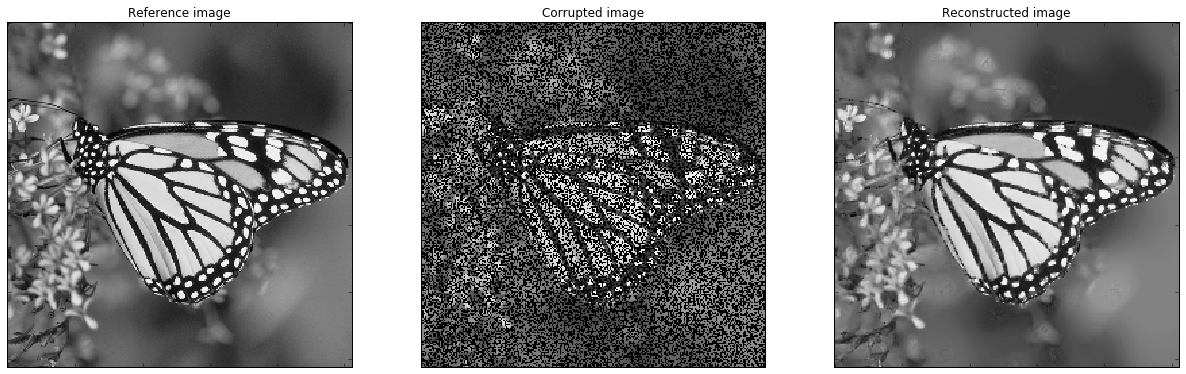

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, fig=fig, title='Reference image')
plot.subplot(1, 3, 2)
plot.imview(imgw, fig=fig, title='Corrupted image')
plot.subplot(1, 3, 3)
plot.imview(imgr, fig=fig, title='Reconstructed image')
fig.show()

Display lowpass component and sparse representation

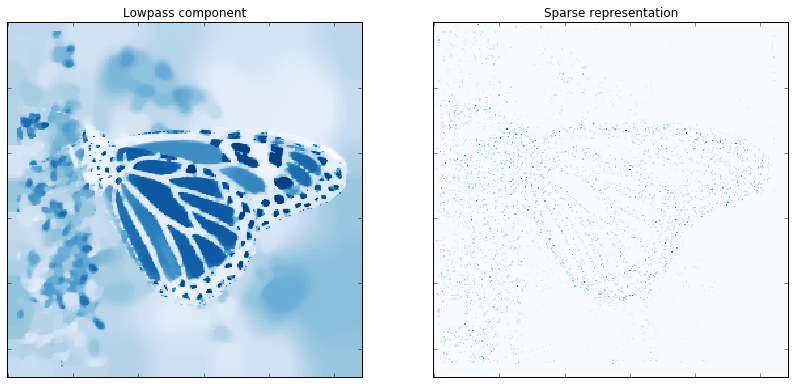

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, fig=fig, cmap=plot.cm.Blues, title='Lowpass component')
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=ams.cri.axisM)), fig=fig,
            cmap=plot.cm.Blues, title='Sparse representation')
fig.show()

Plot functional value, residuals, and rho

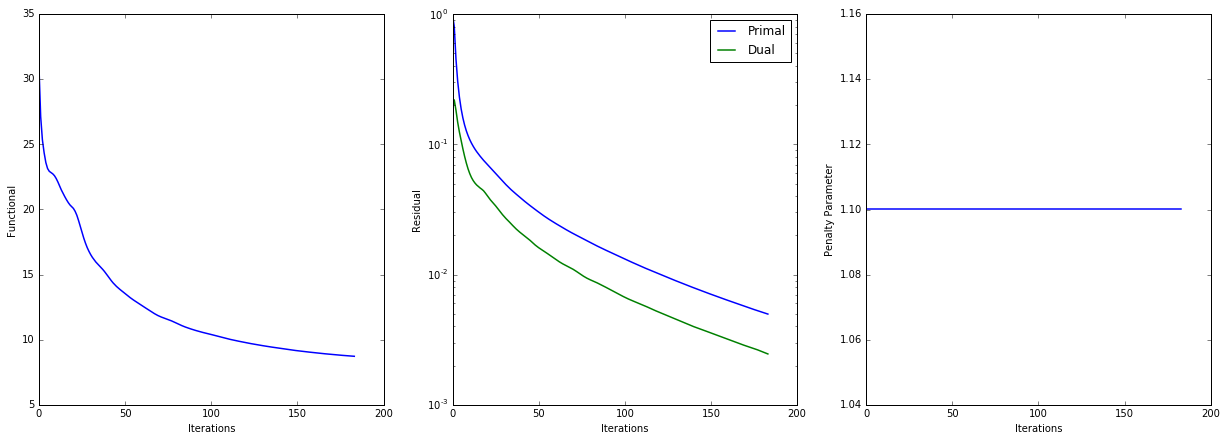

In [14]:
its = ams.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, fig=fig, xlbl='Iterations', ylbl='Functional')
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, fig=fig,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.subplot(1, 3, 3)
plot.plot(its.Rho, fig=fig, xlbl='Iterations', ylbl='Penalty Parameter')
fig.show()